# Data Mining on Sentiment Analysis

---

## Preliminaries

Import libraries. **You can add other libraries if necessary.**

In [1]:
from collections import Counter
from collections import defaultdict
import nltk
from nltk import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re  
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import train_test_split  
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\29230\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\29230\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load the data and add column keys.

In [2]:
train_data = pd.read_csv("data/sentiment_train.csv", header=None)
test_data = pd.read_csv("data/sentiment_test.csv", header=None)
train_data.columns = ['id', 'information', 'type', 'text']
test_data.columns = ['id', 'information', 'type', 'text']

Take a glance at the provided data.

In [3]:
train_data.info()
train_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           74682 non-null  int64 
 1   information  74682 non-null  object
 2   type         74682 non-null  object
 3   text         73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


Each item consists of 4 columns, where Columns ID and Information are almost task-irrevalent. **Column Type is users' sentiments, which we should predict as our labels based on Column Text.**
Now let's take a look at possible values of Column Type.

In [4]:
train_data["type"].value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: type, dtype: int64

In [5]:
test_data["type"].value_counts()

Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: type, dtype: int64

There are 4 possible values, and ***our goal is to perform the quadruple classification over texts.***

---

## Data Processing

To prepare the data for the text analysis, we should:
- Filter texts with only letters and numbers
- Turn the texts into lower case
> **TODO**

Complete the `preprocess` function, which takes a piece of texts as input (not necessary of type `str`), you should convert it to `str`, and outputs the preprocessed string.  
Some functions that might be helpful:
- `re.sub`
- `str.lower`

In [6]:
def preprocess(text):
    # Convert input to str if it's not already
    text = str(text)
    # Remove any non-alphanumeric characters using regex
    text = re.sub(r'\W+', ' ', text)
    # Convert text to lower case
    text = text.lower()
    return text

Perform preprocessing, and compare the raw text and the preprocessed tokens.

In [7]:
train_data["clean"] = train_data.text.apply(preprocess)
test_data["clean"] = test_data.text.apply(preprocess)
train_data.head(5)

,id,information,type,text,clean
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...


---

## Feature Engineering

The feature engineering with clean texts starts from text tokenization, i.e., split the text into word tokens. Let's see what the tokenization do. It groups all the texts by words stored on a list.

In [8]:
print(train_data.text[6])
print(train_data.clean[6])
print(word_tokenize(train_data.clean[6]))

So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg
so i spent a few hours making something for fun if you don t know i am a huge borderlands fan and maya is one of my favorite characters so i decided to make myself a wallpaper for my pc here is the original image versus the creation i made enjoy pic twitter com mlsi5wf9jg
['so', 'i', 'spent', 'a', 'few', 'hours', 'making', 'something', 'for', 'fun', 'if', 'you', 'don', 't', 'know', 'i', 'am', 'a', 'huge', 'borderlands', 'fan', 'and', 'maya', 'is', 'one', 'of', 'my', 'favorite', 'characters', 'so', 'i', 'decided', 'to', 'make', 'myself', 'a', 'wallpaper', 'for', 'my', 'pc', 'here', 'is', 'the', 'original', 'image', 'versus', 'the', 'creation', 'i', 'made', 'enjoy', 'pic', 'twitter', 'com', 'mlsi5wf9jg']


We can count the total number of tokens in the training data.

In [9]:
len(set(token for text in train_data.clean for token in word_tokenize(text)))

31111

Stop words are the words in a stop list which are filtered out (i.e. stopped) before or after processing of natural language data (text) because they are insignificant. We can refer to `nltk.corpus.stopwords` to obtain the stop words to use.

In [10]:
stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords_nltk.words('english')
print(len(stop_words), stop_words[:10])

179 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


With text tokenization tools, we can conduct feature engineering on texts with stop words filtered out.

For simplification, we mainly consider two possible features:
- **Word count**: a vector with the dimension of the number of tokens, the value in each dimension is the number of occurrences of the corresponding word token.
- **TF-IDF (Term Frequency-Inverse Document Frequency)**: a "weighted version" of word count, each value is the term frequency (normalized by total number of tokens) multiplies the inverse of the frequency of documents consisting this word token. For details please refers to https://en.wikipedia.org/wiki/Tf%E2%80%93idf.

> **TODO**
Sklearn provides the implementation of the two feature extraction methods, and the interface is in the following. **You should manually re-implement at least one of them in our provided framework.**

*Hint: if you are concerned about the too large dimension, which might slow the model inference, there are three possible solutions which you can have a try:*
- *Hashing: hash the vector into low dimensions with a function from high-dimension index to lower one. We provide a simple hash function and you can also implement a complex one.*
- *Random projection: project the vector into low-dimension space with a fixed random projection. We provide a simple projection method.*
- *Sparsity: use sparse matrices instead of dense ones, which is used in sklearn's implementation. Please refer to https://docs.scipy.org/doc/scipy/reference/sparse.html for more details.*

Here, I manually implement the **Word Count** feature extractor as the following codes show:

In [11]:
class ManualVectorizer(object):
    """
    Manual vectorizer.
    """
    def __init__(self, tokenizer, stop_words):
        """
        Initialize the vectorizer.
        """
        self.tokenizer = tokenizer
        self.stop_words = stop_words
        self.vocabulary = defaultdict(int)

    def fit_transform(self, texts):
        """
        Fit the dictionary and other attributes (such as IDF) with the texts, and then perform feature extraction.
        This method is used on training data.

        Parameters:
            raw_documents (List[str]): a list of untokenized texts.

        Return:
            np.array: a 2-D array where each row refers to the feature vector of the corresponding text.
        """
        tokenized_texts = [self.tokenizer(text) for text in texts]
        filtered_texts = [[token for token in text if token not in self.stop_words] for text in tokenized_texts]

        self.build_vocabulary(filtered_texts)

        feature_vectors = np.zeros((len(texts), len(self.vocabulary)))
        for i, text in enumerate(filtered_texts):
            for token in text:
                if token in self.vocabulary:
                    feature_vectors[i, self.vocabulary[token]] += 1

        return feature_vectors

    def transform(self, texts):
        """
        Perform feature extraction with the learned dictionary and other attributes.
        This method is used on test data.
        Note: if a word token does not appear in training data, it will not be counted as the test feature.

        Parameters:
            raw_documents (List[str]): a list of untokenized texts.

        Return:
            np.array or np.matrix: a 2-D array where each row refers to the feature vector of the corresponding text.
        """
        tokenized_texts = [self.tokenizer(text) for text in texts]
        filtered_texts = [[token for token in text if token not in self.stop_words] for text in tokenized_texts]

        feature_vectors = np.zeros((len(texts), len(self.vocabulary)))
        for i, text in enumerate(filtered_texts):
            for token in text:
                if token in self.vocabulary:
                    feature_vectors[i, self.vocabulary[token]] += 1

        return feature_vectors

    def build_vocabulary(self, filtered_texts):
        for text in filtered_texts:
            for token in text:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)

In [12]:
wordcount_extractor = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words,
)

tfidf_extractor = TfidfVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words,
)

manual_extractor = ManualVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words,
)

extractor = tfidf_extractor # TODO: you can modify here

In [13]:
class Identity(object):
    """
    Do nothing.
    """
    def __init__(self):
        pass

    def __call__(self, xs):
        return xs


class VectorHasher(object):
    """
    Vector hasher for dimension reduction.
    """
    def __init__(self, target_length=100, hash_func=None):
        self.target_length = target_length
        if hash_func is None:
            self.hash_func = lambda x: x % self.target_length
        else:
            self.hash_func = hash_func
    
    def __call__(self, xs):
        hashed_xs = np.matrix(xs.shape[:-1] + (self.target_length, ))
        for idx in range(xs.shape[-1]):
            hashed_idx = self.hash_func(idx)
            hashed_xs[:, hashed_idx] += xs[:, idx].flatten()
        return hashed_xs


class VectorProjector(object):
    """
    Vector projector for dimension reduction.
    """
    def __init__(self, source_length, target_length=100):
        self.projector = np.random.normal(size=(source_length, target_length))
    
    def __call__(self, xs):
        return xs @ self.projector
    

class VectorSVD(object):
    def __init__(self, n_components=100, random_state=42):
        self.svd_transformer = TruncatedSVD(n_components=n_components, random_state=random_state)
        self.is_fit = False

    def fit(self, X):
        self.svd_transformer.fit(X)
        self.is_fit = True

    def transform(self, X):
        if not self.is_fit:
            raise RuntimeError("You must fit the transformer before transforming data!")
        return self.svd_transformer.transform(X)
    
    def __call__(self, X):
        return self.transform(X)

In actual training, I found that dimension reduction recommended methods above did not work well. Therefore I use Truncated SVD. \
Truncated SVD works well with sparse data and is often used in NLP for dimensionality reduction. It operates directly on the data matrix, rather than on the covariance matrix like PCA, making it more suitable for sparse data.

In [14]:
X_train_highdim = extractor.fit_transform(train_data.clean)
X_test_highdim = extractor.transform(test_data.clean)

identity = Identity()
hasher = VectorHasher()
projector = VectorProjector(X_train_highdim.shape[1])
svd_transformer = VectorSVD()
svd_transformer.fit(X_train_highdim)

vector_post_process = svd_transformer # TODO: you can modify here

c:\Users\29230\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [15]:
X_train_raw = vector_post_process(X_train_highdim)
X_test = vector_post_process(X_test_highdim)
print(X_train_raw.shape, X_test.shape)

(74682, 100) (1000, 100)


For label features, it is natual to assign each label name with an index.

In [16]:
name_to_index = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2,
    "Irrelevant": 3,
}
y_train_raw = np.asarray(train_data.type.apply(lambda x: name_to_index[x]))
y_test = np.asarray(test_data.type.apply(lambda x: name_to_index[x]))
y_train_raw[:120], y_train_raw.shape, y_test.shape

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
        0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 (74682,),
 (1000,))

---

## Model Selection

In order to train a model and perform model selection, we should split the raw training data into *training data* and *validation data*
> **TODO**

**Split the data into training data and validation data with proper ratio. You can use `train_test_split` function.**

In [17]:
# Split the training data into training and validation sets using feature vectors and labels.
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(59745, 100) (14937, 100) (59745,) (14937,)


In [18]:
# Split the training data into training and validation w/o vectorization for Bert
X_train2, X_val2, y_train2, y_val2 = train_test_split(train_data.clean, y_train_raw, test_size=0.2, random_state=42)
X_train2 = X_train2.reset_index(drop=True)
X_val2 = X_val2.reset_index(drop=True)
X_test2 = test_data.clean

Now it's time to train your models and select the best ones.

> **TODO**

**Train your model on `X_train` and `y_train`, and select your model on `X_val` and `y_val`**

We provide an example of `DecisionTreeClassifier`. Now it's time for you to select the model you like to conduct classification.

> Requirements
- Select at least **three** other Machine Learning classification models and train them on the train split. And among them you should implement at least **one** by yourself with our provided interface.

### MLP

In [19]:
class ManualModel(object):
    """
    Manual model with sklearn-style interface, MLP
    """
    def __init__(self, input_dim, hidden_dim=128, output_dim=4, dropout_rate=0, lr=1e-3, weight_decay=1e-5):
        """
        Initialize the model with some hyperparameters.

        Parameters:
            input_dim: the dimension of input features.
            hidden_dim: the dimension of hidden layer.
            output_dim: the number of output classes.
            dropout_rate: the rate of dropout.
            lr: learning rate.
            weight_decay: the rate of weight decay.
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim),
        ).to(self.device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr
        self.weight_decay = weight_decay
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=200, gamma=0.1)

    def fit(self, X, y, batch_size=64, num_epochs=400):
        """
        Fit the model on training set.

        Parameters:
            X: inputs of training data.
            y: labels of training data.
            num_epochs: the number of epochs to train.
        """
        self.model.train()
        X_tensor = torch.tensor(X, dtype=torch.float).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(self.device)
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # for epoch in tqdm(range(num_epochs), desc="Fitting"):
        for epoch in range(num_epochs):
            train_loss = 0.0
            train_acc = 0.0
            for batch_X, batch_y in dataloader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                # Forward pass
                logits = self.model(batch_X)

                # Calculate loss
                loss = self.loss_fn(logits, batch_y)
                train_loss += loss.item()
                acc = torch.sum(torch.argmax(logits, dim=1) == batch_y).item() / len(batch_y)
                train_acc += acc

                # Zero the gradients
                self.optimizer.zero_grad()
                # Backward pass
                loss.backward()
                # Update the parameters
                self.optimizer.step()
                
            self.scheduler.step()
            # print("Epoch: {}, Train Loss: {}, Train Accuracy: {}".format(epoch+1, train_loss/len(dataloader), train_acc/len(dataloader)))
            

    def predict(self, X):
        """
        Predict the labels of inputs X with the trained model.

        Parameters:
            X: inputs of test data
        
        Return:
            The predicted labels of test data.
        """
        self.model.eval()
        with torch.no_grad():
            X = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.model(X)
            _, prds = torch.max(outputs, dim=1)
        return prds.cpu().numpy()

### Use Bert for classification
In this model, I extract the embedded representation from the pre-trained BERT, pool all embeddings to get an effective representation of the sentence, and feed into a fully connected layer to implement text classification.

In [20]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes) # 768 -> 4

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask) # word embedding
        pooled_output = output.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits # we don't need softmax here because we'll use cross-entropy as activation.
    
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {'input_ids': encoding['input_ids'].squeeze(),
                'attention_mask': encoding['attention_mask'].squeeze(),
                'label': torch.tensor(label, dtype=torch.long)}

def train_bert_classifier(model, batches, loss_fn, optimizer, device, n_examples):
    model.train()
    correct_predictions = 0
    total_loss = 0

    for batch in tqdm(batches, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return total_loss / n_examples, correct_predictions.double() / n_examples

def eval_bert_classifier(model, batches, loss_fn, device, n_examples):
    model.eval()
    correct_predictions = 0
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(batches, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            total_loss += loss.item()

    return total_loss / n_examples, correct_predictions.double() / n_examples

### TextResNet

In [21]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels, kernel_size=9):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, num_channels, kernel_size, padding = kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.dropout = nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size, padding = kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(num_channels)
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class AttentivePooling(nn.Module):
    def __init__(self, num_channels):
        super(AttentivePooling, self).__init__()
        self.attention = nn.Linear(num_channels, 1) # Linear layer to compute attention scores

    def forward(self, x):
        # Compute attention scores
        scores = self.attention(x.transpose(1, 2))  # Shape: (batch_size, seq_len, channels)
        scores = F.softmax(scores, dim=1)  # Apply softmax over the sequence dimension, shape: (batch_size, seq_len, 1)

        # Compute weighted sum of features
        x = x * scores.transpose(1, 2)  # Shape: (batch_size, num_channels, seq_len)
        x = x.sum(dim=2)  # Shape: (batch_size, num_channels)

        return x
    
class TextResNetClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, kernel_size=9, num_channels=256):
        super(TextResNetClassifier, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, num_channels, kernel_size, padding = kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.resblocks = nn.ModuleList([ResidualBlock(num_channels) for _ in range(8)])
        self.pooling = AttentivePooling(num_channels)
        self.fc = nn.Linear(num_channels, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        for resblock in self.resblocks:
            x = resblock(x)
        x = self.pooling(x)  # Attentive pooling
        out = self.fc(x)
        return out


def train_res_classifier(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:
        inputs, labels = batch
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        acc = (predictions.argmax(1) == labels).float().mean()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate_res_classifier(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            inputs, labels = batch
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            acc = (predictions.argmax(1) == labels).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Function to view log 

In [22]:
def view_line(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    for line in lines:
        print(line, end='')

**Training Bert:** \
The training requires high GPU performance and long time. \
**Notice:**  You can **skip** the step and directly view the training records in the log

In [ ]:
# **Notice:** You can skip this cell if you want to save time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up tokenizer, use to convert text to tokens
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # lowercase text

# Hyperparameters
max_length = 64 # max length of tokens
batch_size = 64 
num_classes = 4 
num_epochs = 100
learning_rate = 2e-5

# Create model, optimizer, and loss function
model = BertClassifier(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Create Dataset
train_dataset = TextDataset(X_train2, y_train2, tokenizer, max_length)
val_dataset = TextDataset(X_val2, y_val2, tokenizer, max_length)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # usually we don't shuffle validation and test sets

# Train and evaluate the model
for epoch in range(num_epochs):
    train_loss, train_acc = train_bert_classifier(model, train_loader, loss_fn, optimizer, device, len(train_dataset))
    val_loss, val_acc = eval_bert_classifier(model, val_loader, loss_fn, device, len(val_dataset))
    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    with open ("bert_2.log", "a") as f:
        f.write(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

In [23]:
view_line('logs/bert_2.log')

Epoch: 1, Train Loss: 0.0140, Train Acc: 0.6379, Val Loss: 0.0101, Val Acc: 0.7567
Epoch: 2, Train Loss: 0.0071, Train Acc: 0.8330, Val Loss: 0.0059, Val Acc: 0.8672
Epoch: 3, Train Loss: 0.0034, Train Acc: 0.9195, Val Loss: 0.0050, Val Acc: 0.8906
Epoch: 4, Train Loss: 0.0022, Train Acc: 0.9451, Val Loss: 0.0046, Val Acc: 0.9063
Epoch: 5, Train Loss: 0.0018, Train Acc: 0.9546, Val Loss: 0.0046, Val Acc: 0.9054
Epoch: 6, Train Loss: 0.0015, Train Acc: 0.9591, Val Loss: 0.0047, Val Acc: 0.9096
Epoch: 7, Train Loss: 0.0014, Train Acc: 0.9609, Val Loss: 0.0047, Val Acc: 0.9134
Epoch: 8, Train Loss: 0.0013, Train Acc: 0.9617, Val Loss: 0.0047, Val Acc: 0.9162
Epoch: 9, Train Loss: 0.0013, Train Acc: 0.9648, Val Loss: 0.0047, Val Acc: 0.9173
Epoch: 10, Train Loss: 0.0013, Train Acc: 0.9642, Val Loss: 0.0045, Val Acc: 0.9164
Epoch: 11, Train Loss: 0.0012, Train Acc: 0.9667, Val Loss: 0.0046, Val Acc: 0.9186
Epoch: 12, Train Loss: 0.0012, Train Acc: 0.9661, Val Loss: 0.0049, Val Acc: 0.9185
E

**Training TextResNet:**\
The training requires high GPU performance and long time. \
**Notice:**  You can **skip** the step and directly view the training records in the log

In [ ]:
# **Notice:** You can skip this cell if you want to save time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data into tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float).unsqueeze(1).to(device)  # add dimension at position 1
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float).unsqueeze(1).to(device)  # add dimension at position 1
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

# Create datasets and data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Initialize model
num_classes = 4
input_dim = 1
model = TextResNetClassifier(input_dim, num_classes).to(device)

# Set up training
learning_rate = 0.001
num_epochs = 1000

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(num_epochs):
    train_loss, train_acc = train_res_classifier(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate_res_classifier(model, val_loader, criterion)

    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    with open ("res4.log", "a") as f:
        f.write(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

In [24]:
view_line('logs/res4.log')

Epoch: 1, Train Loss: 1.2841, Train Acc: 0.4204, Val Loss: 1.2050, Val Acc: 0.4691
Epoch: 2, Train Loss: 1.1756, Train Acc: 0.4844, Val Loss: 1.1708, Val Acc: 0.4875
Epoch: 3, Train Loss: 1.1453, Train Acc: 0.5009, Val Loss: 1.1218, Val Acc: 0.5152
Epoch: 4, Train Loss: 1.1226, Train Acc: 0.5114, Val Loss: 1.1100, Val Acc: 0.5169
Epoch: 5, Train Loss: 1.0991, Train Acc: 0.5243, Val Loss: 1.0829, Val Acc: 0.5367
Epoch: 6, Train Loss: 1.0761, Train Acc: 0.5384, Val Loss: 1.0625, Val Acc: 0.5433
Epoch: 7, Train Loss: 1.0529, Train Acc: 0.5455, Val Loss: 1.0519, Val Acc: 0.5508
Epoch: 8, Train Loss: 1.0247, Train Acc: 0.5611, Val Loss: 1.0301, Val Acc: 0.5582
Epoch: 9, Train Loss: 0.9993, Train Acc: 0.5731, Val Loss: 1.0179, Val Acc: 0.5631
Epoch: 10, Train Loss: 0.9682, Train Acc: 0.5877, Val Loss: 0.9712, Val Acc: 0.5888
Epoch: 11, Train Loss: 0.9386, Train Acc: 0.6035, Val Loss: 0.9503, Val Acc: 0.6018
Epoch: 12, Train Loss: 0.9048, Train Acc: 0.6198, Val Loss: 0.9314, Val Acc: 0.6158
E

### Model assess

In [25]:
name_acc_list = {
    "name": [],
    "acc": []
}

def model_assess(model, name='Default'):
    
    if name == "BERT":
        max_length = 64 
        loss_fn = nn.CrossEntropyLoss()
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        val_dataset = TextDataset(X_val2, y_val2, tokenizer, max_length)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False) # If your GPU memory is not enough, reduce the batch_size
        
        _, val_acc = eval_bert_classifier(model, val_loader, loss_fn, device, len(val_dataset))
        val_acc = val_acc.item() * 100 
        name_acc_list["name"].append(name)
        name_acc_list["acc"].append(val_acc)
        
        print(f'Model: {name}, Accuracy: {val_acc}%')
        
    
    elif name == "TextResNet":
        criterion = nn.CrossEntropyLoss()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
        X_val_tensor = torch.tensor(X_val, dtype=torch.float).unsqueeze(1).to(device)  
        y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
        
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # If your GPU memory is not enough, reduce the batch_size
        
        _, val_acc = evaluate_res_classifier(model, val_loader, criterion)
        val_acc = val_acc * 100 
        name_acc_list["name"].append(name)
        name_acc_list["acc"].append(val_acc)
        
        print(f'Model: {name}, Accuracy: {val_acc}%') 
        
    else:
        model.fit(X_train, y_train)
        prds = model.predict(X_val)
        acc = 100 * accuracy_score(y_val, prds)
        name_acc_list["name"].append(name)
        name_acc_list["acc"].append(acc)
        print(f'Model: {name}, Accuracy: {acc}%')

**DecisionTree** and **RandomForest** implemented by sklearn

In [26]:
model_0 = DecisionTreeClassifier()
model_assess(model_0, "DT")

model_1 = RandomForestClassifier()
model_assess(model_1, "RF")

Model: DT, Accuracy: 65.17372966459128%
Model: RF, Accuracy: 79.35997857668876%


**MLP**： 
The fitting requires time. You can directly use the `mlp_classifier.pth` I trained before.

In [27]:
# NOTICE: this code will fit again, so it will take some time, if you want to save time, you can skip this cell
model_2 = ManualModel(X_train.shape[1])
model_assess(model_2, "MLP")

Model: MLP, Accuracy: 73.82339157796078%


In [28]:
# directly use the model fitted in the previous section
model_2 = ManualModel(X_train.shape[1])
model_2.model.load_state_dict(torch.load("models/mlp_classifier.pth"))
prds = model_2.predict(X_val)
acc = 100 * accuracy_score(y_val, prds)
name_acc_list["name"].append('MLP')
name_acc_list["acc"].append(acc)
print(f'Model: MLP, Accuracy: {acc}%')

Model: MLP, Accuracy: 73.89033942558747%


**Bert** and **TextResNet**:
We assess the model I trained before, because retraining takes a lot of time \
If your GPU memory is not enough, reduce the batch_size as I write in function `model_assess`

In [29]:
# BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model_3 = BertClassifier(4).to(device)
model_3.load_state_dict(torch.load("models/bert_classifier.pth"))
model_assess(model_3, "BERT")
del model_3
torch.cuda.empty_cache()

# TextResNet
model_4 = TextResNetClassifier(1, 4).to(device)
model_4.load_state_dict(torch.load("models/resnet_classifier.pth"))
model_assess(model_4, "TextResNet")
del model_4
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluating: 100%|██████████| 934/934 [00:37<00:00, 25.13it/s]


Model: BERT, Accuracy: 93.13784561826338%
Model: TextResNet, Accuracy: 81.03907922605886%


Visualize the assess results

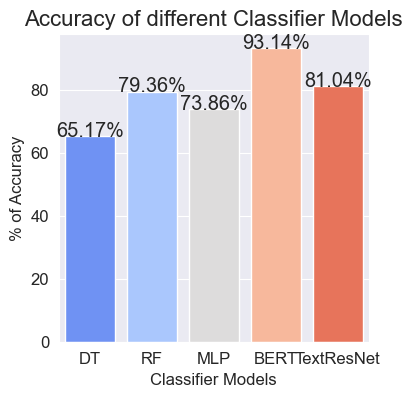

In [30]:
def plot_acc():
    plt.rcParams['figure.figsize']=4,4
    sns.set_style('darkgrid')
    ax = sns.barplot(x=name_acc_list["name"], y=name_acc_list["acc"], palette="coolwarm", saturation=2.0)
    plt.xlabel('Classifier Models', fontsize=12)
    plt.ylabel('% of Accuracy', fontsize=12)
    plt.title('Accuracy of different Classifier Models', fontsize=16)
    plt.xticks(fontsize=12, horizontalalignment='center')
    plt.yticks(fontsize=12)
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize='x-large')
    plt.show()
    
plot_acc()


### **Tune model for good performance on validation set.**

**Note:** you should only tune your model on the validation set, and keep the test data **unseen until the model is selected**.

Now it is your time to provide the final solution.

> Requirements
- Tune model's hyperparameters evaluate all your selected models. And give a detailed report on the **performance** and **computational efficiency**.
- Evaluate your final model on test set, and report the final result.
- It is appreciated if other machine learning techniques that help to improve performance are employed.

#### Tune models for classification

##### Bert
Refer to the log file and the training experience, I found that the following set of parameters works well:

> max length of tokens: 64,\
batch size = 64, \
epochs = 75, \
learning rate = 2e-5,\
dropout rate = 0.1

The training techniques were used include: Dropout, ADAM.

The training requires high GPU performance and time. Each epoch takes about 3 minutes on `NVIDIA A100 80GB PCIe`, so the whole training process takes about 4 hours. The GPU memory usage is approximately 5641 MiB.

You can **SKIP** the following TRAINING step and directly use the `bert_classifier.pth` I trained before


In [81]:
# **NOTICE:** You can skip this cell if you want to save time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up tokenizer, use to convert text to tokens
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # lowercase text

# Hyperparameters
max_length = 64 # max length of tokens
batch_size = 64 
num_classes = 4 
num_epochs = 75
learning_rate = 2e-5

# Create model, optimizer, and loss function
model = BertClassifier(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Create Dataset
train_dataset = TextDataset(X_train2, y_train2, tokenizer, max_length)
val_dataset = TextDataset(X_val2, y_val2, tokenizer, max_length)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # usually we don't shuffle validation and test sets

# Train and evaluate the model
for epoch in range(num_epochs):
    train_loss, train_acc = train_bert_classifier(model, train_loader, loss_fn, optimizer, device, len(train_dataset))
    val_loss, val_acc = eval_bert_classifier(model, val_loader, loss_fn, device, len(val_dataset))
    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), "models/bert_classifier.pth")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluating: 100%|██████████| 467/467 [00:54<00:00,  8.62it/s]

Epoch: 1, Train Loss: 0.0266, Train Acc: 0.6572, Val Loss: 0.0169, Val Acc: 0.7974


##### TestResNet 
Refer to the log file and the training experience, I found that the following set of parameters works well:

> batch size = 32, \
learning rate = 0.001, \
epochs = 890,  \
dropout rate = 0.5, \
kernel size = 9, \
num channels = 256, 


The training techniques were used include: Batch Normalization (BN), Dropout, ADAM

The training requires high GPU performance and time. 
Each epoch takes about 30 seconds on `NVIDIA A100 80GB PCIe`, so the whole training process takes about 7-8 hours. The GPU memory usage is approximately 1881 MiB.

You can **SKIP** following TRAINING step and directly use the `resnet_classifier.pth` I trained before

In [79]:
# **NOTICE:** You can skip this cell if you want to save time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data into tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float).unsqueeze(1).to(device)  # add dimension at position 1
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float).unsqueeze(1).to(device)  # add dimension at position 1
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

# Create datasets and data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Initialize model
num_classes = 4
input_dim = 1
model = TextResNetClassifier(input_dim, num_classes).to(device)

# Set up training
learning_rate = 0.001
num_epochs = 890

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(num_epochs):
    train_loss, train_acc = train_res_classifier(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate_res_classifier(model, val_loader, criterion)
    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

torch.save(model.state_dict(), "models/resnet_classifier.pth")

Epoch: 1, Train Loss: 1.2714, Train Acc: 0.4335, Val Loss: 1.1827, Val Acc: 0.4818
Epoch: 2, Train Loss: 1.1731, Train Acc: 0.4862, Val Loss: 1.1724, Val Acc: 0.4804


##### MLP 
Refer to the training experience, I have tune the parameters as the shown in ManualModel class:

> batch size = 64, \
Initial learning rate = 0.001, decay every 200 epochs\
epochs = 400,  \
dropout rate = 0, \
hidden dimension = 128,\
weight decay=1e-5     

The training techniques were used include:
learning rate decay, wight decay, ADAM

Each epoch takes about 1.5 seconds on `NVIDIA A100 80GB PCIe`, so the whole training process takes about 10 minutes. The GPU memory usage is approximately 1317 MiB.

The training requires time. You are recommended to use the `mlp_classifier.pth` I trained before.

##### Evaluate final model on test set 
When using the test set evaluation model, you may encounter the situation that the GPU memory is insufficient. \
In this case, please adjust `batch_size` according to the comments below. `batch_size` can be reduce to 1


In [31]:
name_eval_list = {
    "name": [],
    "acc": []
}

def model_eval(model, name='Default'):
    if name == "BERT":
        max_length = 64
        loss_fn = nn.CrossEntropyLoss()
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        test_dataset = TextDataset(X_test2, y_test, tokenizer, max_length)  
        test_loader = DataLoader(test_dataset, batch_size= 16, shuffle=False)  # If your GPU memory is not enough, reduce the batch_size
        
        _, acc = eval_bert_classifier(model, test_loader, loss_fn, device, len(test_dataset))
        acc = acc.item() * 100 
        name_eval_list["name"].append(name)
        name_eval_list["acc"].append(acc)
        print(f'Model: {name}, Accuracy: {acc}%')
        
    elif name == "TextResNet":
        criterion = nn.CrossEntropyLoss()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        X_test_tensor = torch.tensor(X_test, dtype=torch.float).unsqueeze(1).to(device)  
        y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # If your GPU memory is not enough, reduce the batch_size
        
        _, acc = evaluate_res_classifier(model, test_loader, criterion)
        acc = acc * 100 
        name_eval_list["name"].append(name)
        name_eval_list["acc"].append(acc)
        print(f'Model: {name}, Accuracy: {acc}%') 
         
    else:
        prds = model.predict(X_test)
        acc = 100 * accuracy_score(y_test, prds)
        name_eval_list["name"].append(name)
        name_eval_list["acc"].append(acc)
        print(f'Model: {name}, Accuracy: {acc}%')

In [32]:
# Decision Tree, Random Forest, MLP
model_eval(model_0, "DT")
model_eval(model_1, "RF")
model_eval(model_2, "MLP")

# BERT, TextResNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model_3 = BertClassifier(4).to(device)
model_3.load_state_dict(torch.load("models/bert_classifier.pth"))
model_eval(model_3, "BERT")
del model_3
torch.cuda.empty_cache()

model_4 = TextResNetClassifier(1, 4).to(device)
model_4.load_state_dict(torch.load("models/resnet_classifier.pth"))
model_eval(model_4, "TextResNet")
del model_4
torch.cuda.empty_cache()

Model: DT, Accuracy: 84.2%
Model: RF, Accuracy: 90.10000000000001%
Model: MLP, Accuracy: 85.7%


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluating: 100%|██████████| 63/63 [00:02<00:00, 22.89it/s]


Model: BERT, Accuracy: 97.3%
Model: TextResNet, Accuracy: 89.18650793650794%


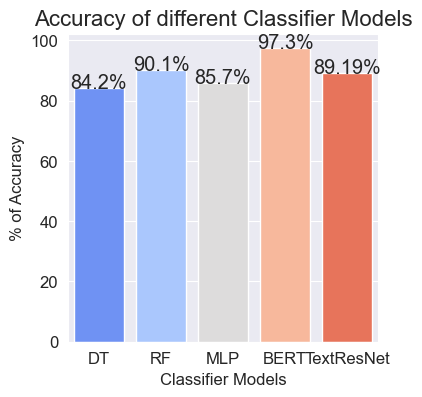

In [33]:
def plot_acc():
    plt.rcParams['figure.figsize']=4,4
    sns.set_style('darkgrid')
    ax = sns.barplot(x=name_eval_list["name"], y=name_eval_list["acc"], palette="coolwarm", saturation=2.0)
    plt.xlabel('Classifier Models', fontsize=12)
    plt.ylabel('% of Accuracy', fontsize=12)
    plt.title('Accuracy of different Classifier Models', fontsize=16)
    plt.xticks(fontsize=12, horizontalalignment='center')
    plt.yticks(fontsize=12)
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize='x-large')
    plt.show()
    
plot_acc()

---